In [2]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [3]:
orbitals = {
    (1, 0, 0): lambda r, theta, phi: np.exp(-r),
    (2, 0, 0): lambda r, theta, phi: (2 - r) * np.exp(-r/2),
    (2, 1, 0): lambda r, theta, phi: r * np.exp(-r/2) * np.cos(theta),
    (2, 1, -1): lambda r, theta, phi: r * np.exp(-r/2) * np.sin(theta) * np.exp(-1j*phi),
    (2, 1, 1): lambda r, theta, phi: r * np.exp(-r/2) * np.sin(theta) * np.exp(1j*phi),
    (3, 0, 0): lambda r, theta, phi: (27 - 18*r + 2*r**2) * np.exp(-r/3),
    (3, 1, 0): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.cos(theta),
    (3, 1, -1): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.sin(theta) * np.exp(-1j*phi),
    (3, 1, 1): lambda r, theta, phi: r * (6 - r) * np.exp(-r/3) * np.sin(theta) * np.exp(1j*phi),
    (3, 2, 0): lambda r, theta, phi: r**2 * np.exp(-r/3) * (3 * np.cos(theta)**2 - 1),
    (3, 2, -1): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta) * np.cos(theta) * np.exp(-1j*phi),
    (3, 2, 1): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta) * np.cos(theta) * np.exp(1j*phi),
    (3, 2, -2): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta)**2 * np.exp(-2j*phi),
    (3, 2, 2): lambda r, theta, phi: r**2 * np.exp(-r/3) * np.sin(theta)**2 * np.exp(2j*phi),
}

orbital_names = {
    (1, 0, 0): "1s",
    (2, 0, 0): "2s",
    (2, 1, 0): "2p_z",
    (2, 1, -1): "2p_y",
    (2, 1, 1): "2p_x",
    (3, 0, 0): "3s",
    (3, 1, 0): "3p_z",
    (3, 1, -1): "3p_y",
    (3, 1, 1): "3p_x",
    (3, 2, 0): "3d_z2",
    (3, 2, -1): "3d_yz",
    (3, 2, 1): "3d_xz",
    (3, 2, -2): "3d_xy",
    (3, 2, 2): "3d_x2-y2",
}

In [4]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def cartesian_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)
    return r, theta, phi

def plane_cartesian_to_spherical(x, y, plane=0):
    match plane:
        case 0: point = (x, y, 0)  # XY plane
        case 1: point = (0, x, y)  # YZ plane
        case 2: point = (y, 0, x)  # ZX plane
    return cartesian_to_spherical(*point)

In [11]:
def sample_distribution(orbital_func, n_samples=10000, plane=0):

    # Find the max
    max = 0
    for i in range(100000):
        x, y = np.random.uniform(-30, 30, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value > max:
            max = value

    # Find the bounds
    bound = 30
    while True:
        r, theta, phi = plane_cartesian_to_spherical(bound, bound, plane)
        value = abs(orbital_func(r, theta, phi))**2
        if value >= max * 0.0001:
            bound += 1
            break
        else:
            bound -= 1

    print(max, bound)

    # Make the samples
    pool = ThreadPoolExecutor(max_workers=8)
    futures = [pool.submit(generate_samples, n_samples // 8, bound, max, orbital_func, plane) for _ in range(8)]
    samples = np.vstack([future.result() for future in futures])
    return samples


def generate_samples(n_samples, bound, max, orbital_func, plane):
    samples = []
    while len(samples) < n_samples:
        x, y = np.random.uniform(-bound, bound, size=2)
        r, theta, phi = plane_cartesian_to_spherical(x, y, plane)
        value = abs(orbital_func(r, theta, phi))**2
        threshold = np.random.uniform(0, max)
        if threshold < value:
            samples.append((x, y))
    return np.array(samples)


0.9285226409200765 4
0.7493724708090594 4
0.8175975049089834 4


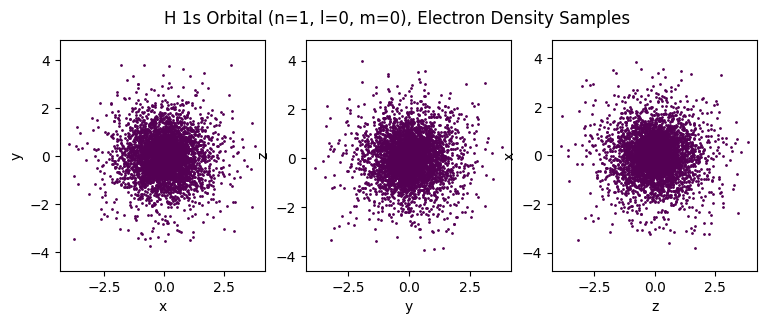

3.698236424509015 9
3.2662252492855504 10
3.6334735904789093 9


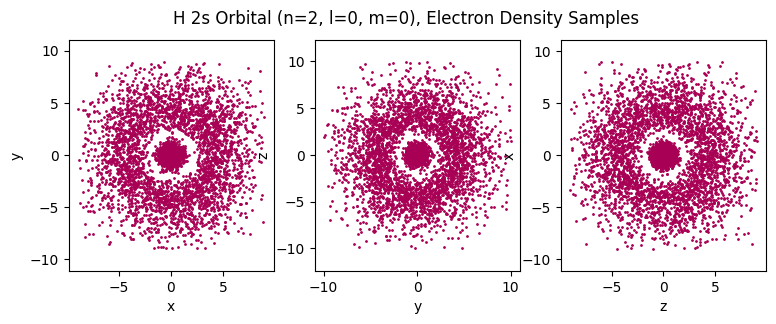

2.029702137804492e-33 11
0.5413336682421691 11
0.5410595230516844 11


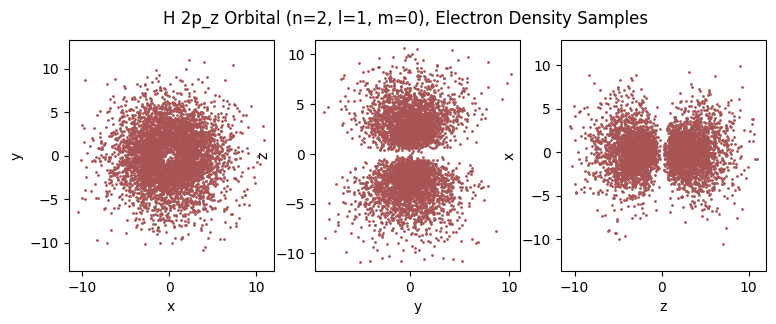

0.5413402771552384 11
0.5407082488346318 11
0.5411542629947703 11


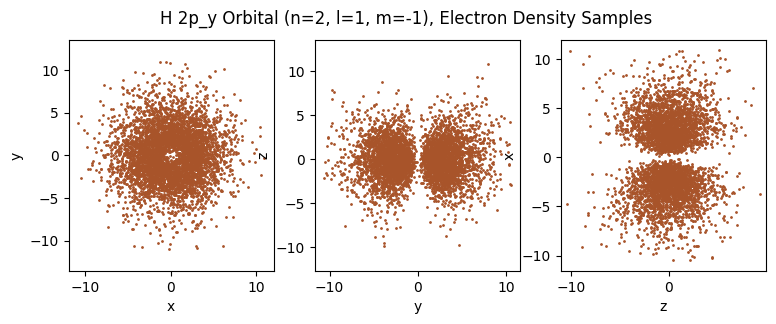

0.5413411329434222 11
0.5412175813143073 11
0.5412054031426463 11


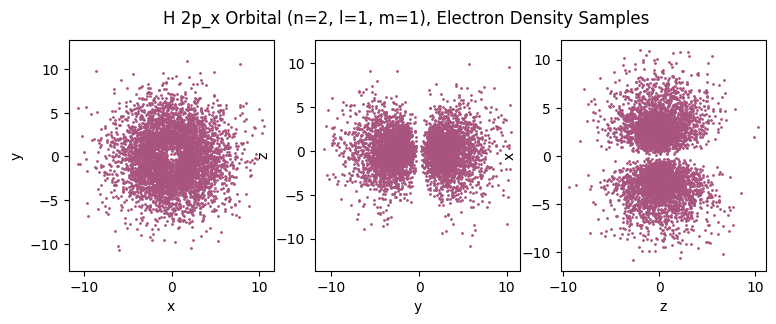

532.3982339114768 18
622.7986208028336 17
719.6708054017209 17


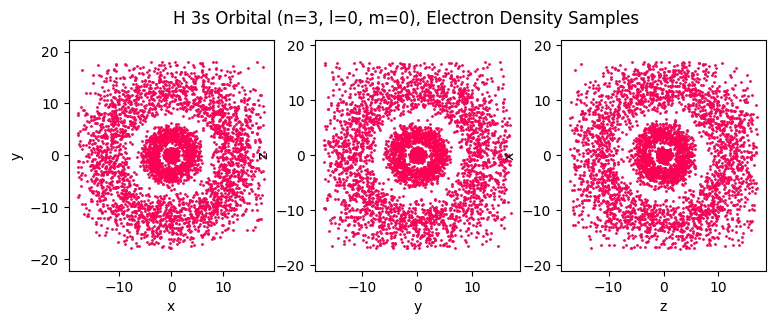

6.458725248339592e-32 21
17.19201675079735 20
17.22566881671445 20


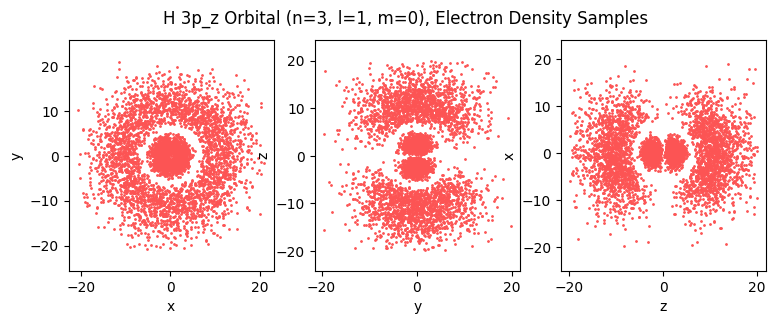

17.22601298646309 21
17.22568384337109 20
17.2221420290955 20


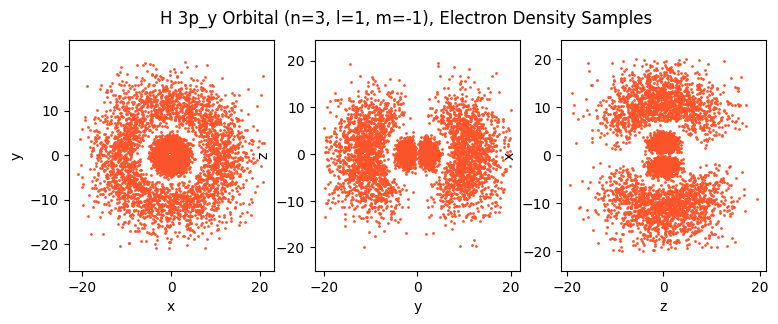

17.226061252475347 21
17.171275219226015 20
17.20497985005277 20


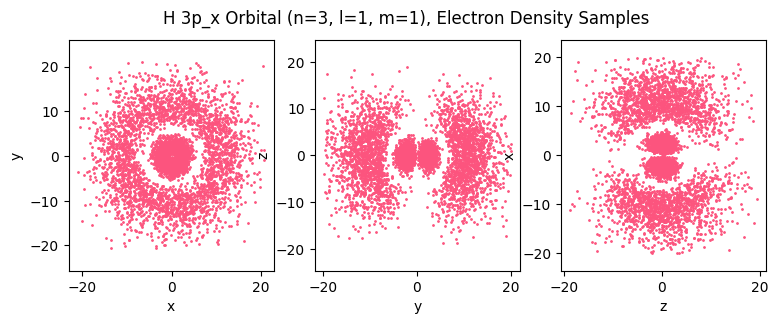

23.73706792738875 21
94.93771075244942 17
94.89857830796531 17


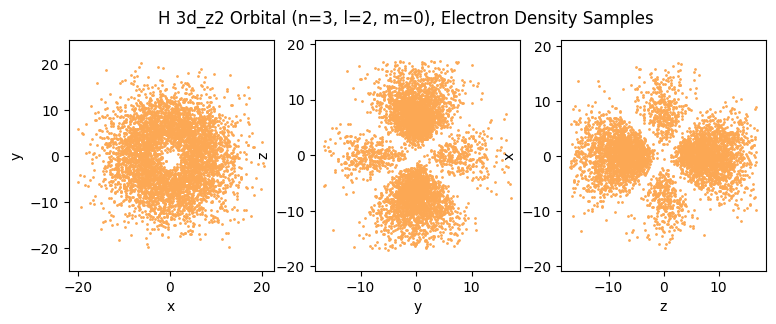

8.89997498547783e-32 21
5.932905456302597 21
5.930016755450185 21


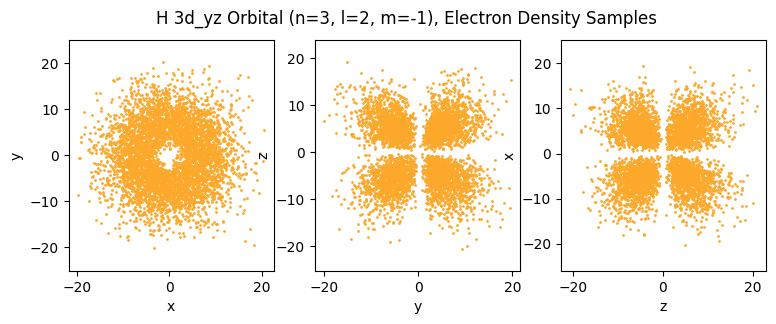

8.89997498184718e-32 21
5.934204490289107 21
5.932812256283578 21


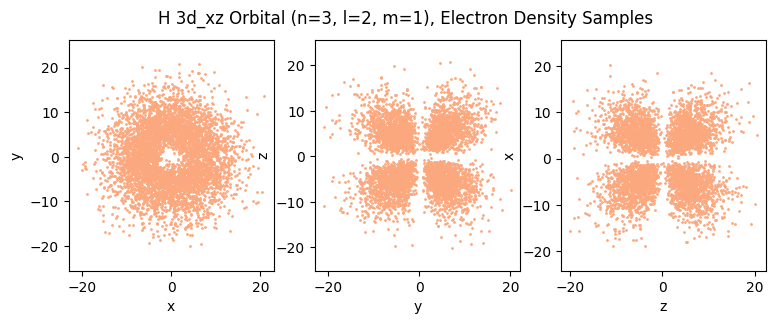

23.737067858499703 21
23.73691737741957 19
23.71942120295532 19


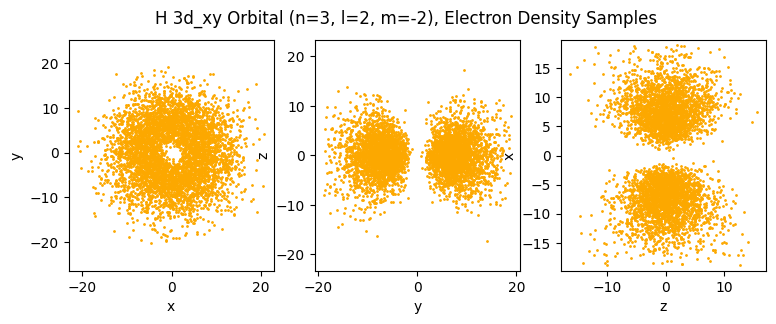

23.737067995657522 21
23.70178495406033 19
23.720061418289873 19


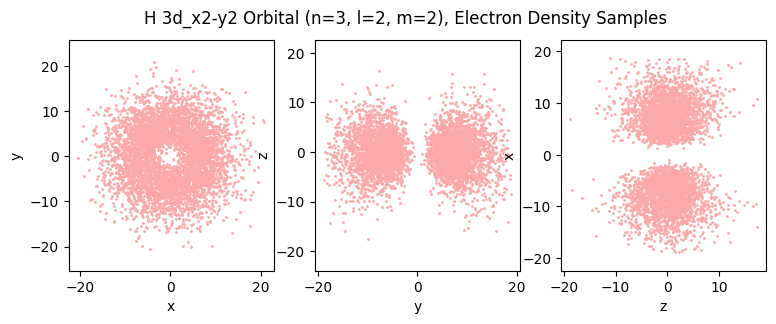

In [12]:
for key in orbitals:
# key = (2, 1, 0)
    orbital = orbitals.get(key)
    n, l, m = key
    samples = 5000
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))
    axes = (("x", "y"), ("y", "z"), ("z", "x"))

    for plane in range(3):
        pts = sample_distribution(orbital, n_samples=samples, plane=plane)
        ax[plane].scatter(pts[:, 0], pts[:, 1], s=1, color=(0.33 * n, 0.33 * l, 0.165 * (m + 2)))
        ax[plane].axis('equal')
        ax[plane].set_xlabel(axes[plane][0])
        ax[plane].set_ylabel(axes[plane][1])

    fig.suptitle("H {name} Orbital (n={n}, l={l}, m={m}), Electron Density Samples".format(name=orbital_names[key], n=n, l=l, m=m))
    plt.show()